In [1]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

/home/mirandalv/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mirandalv/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mirandalv/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mirandalv/anaconda3/lib/python3.6/site-packages/tensorflow/python/f

In [2]:
data_url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip"
data_file_name = "catsdogs.zip"
download_dir = os.path.abspath(".")
urllib.request.urlretrieve(data_url, data_file_name)
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(download_dir)
zip_ref.close()

In [3]:
print("Number of cat images:",len(os.listdir(os.path.join(download_dir, 'PetImages/Cat/'))))
print("Number of dog images:", len(os.listdir(os.path.join(download_dir, 'PetImages/Dog/'))))

Number of cat images: 12501
Number of dog images: 12501


In [18]:
# create training and testing folder
try:
    os.mkdir(os.path.join(download_dir, 'cats-v-dogs'))
    os.mkdir(os.path.join(download_dir, 'cats-v-dogs/training'))
    os.mkdir(os.path.join(download_dir, 'cats-v-dogs/testing'))
    os.mkdir(os.path.join(download_dir, 'cats-v-dogs/training/cats'))
    os.mkdir(os.path.join(download_dir, 'cats-v-dogs/training/dogs'))
    os.mkdir(os.path.join(download_dir, 'cats-v-dogs/testing/cats'))
    os.mkdir(os.path.join(download_dir, 'cats-v-dogs/testing/dogs'))
except OSError:
    pass

In [19]:
# Splitting data into training and test sets

import random
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = os.path.join(TRAINING, filename)
        copyfile(this_file, destination)

    for filename in testing_set:
        this_file = SOURCE + filename
        destination = os.path.join(TESTING, filename)
        copyfile(this_file, destination)


CAT_SOURCE_DIR = os.path.join(download_dir, 'PetImages/Cat/')
TRAINING_CATS_DIR = os.path.join(download_dir, 'cats-v-dogs/training/cats')
TESTING_CATS_DIR = os.path.join(download_dir, 'cats-v-dogs/testing/cats')
DOG_SOURCE_DIR = os.path.join(download_dir, 'PetImages/Dog/')
TRAINING_DOGS_DIR = os.path.join(download_dir, 'cats-v-dogs/training/dogs')
TESTING_DOGS_DIR = os.path.join(download_dir, 'cats-v-dogs/testing/dogs')

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

# Expected output
# 666.jpg is zero length, so ignoring
# 11702.jpg is zero length, so ignoring


666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.


In [20]:
TRAINING_CATS_DIR

'/home/mirandalv/Documents/github/courses/AdvancedTechnicsTF/3_CV/Week1/cats-v-dogs/training/cats'

In [21]:
print("Number of training cat images", len(os.listdir(TRAINING_CATS_DIR)))
print("Number of training dog images", len(os.listdir(TRAINING_DOGS_DIR)))
print("Number of testing cat images", len(os.listdir(TESTING_CATS_DIR)))
print("Number of testing dog images", len(os.listdir(TESTING_DOGS_DIR)))

# expected output
# Number of training cat images 11250
# Number of training dog images 11250
# Number of testing cat images 1250
# Number of testing dog images 1250

Number of training cat images 11250
Number of training dog images 11250
Number of testing cat images 1250
Number of testing dog images 1250


# Data augmentation (try adjusting the parameters)!

Here, you'll use the `ImageDataGenerator` to perform data augmentation.  
- Things like rotating and flipping the existing images allows you to generate training data that is more varied, and can help the model generalize better during training.  
- You can also use the data generator to apply data augmentation to the validation set.

You can use the default parameter values for a first pass through this lab.
- Later, try to experiment with the parameters of `ImageDataGenerator` to improve the model's performance.
- Try to drive reach 99.9% validation accuracy or better.

In [22]:

TRAINING_DIR = os.path.join(download_dir, 'cats-v-dogs/training')
# Experiment with your own parameters to reach 99.9% validation accuracy or better
train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=100,
                                                    class_mode='binary',
                                                    target_size=(150, 150))

VALIDATION_DIR = os.path.join(download_dir, 'cats-v-dogs/testing')

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=100,
                                                              class_mode='binary',
                                                              target_size=(150, 150))



Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


# Get and prepare the model

You'll be using the `InceptionV3` model.  
- Since you're making use of transfer learning, you'll load the pre-trained weights of the model.
- You'll also freeze the existing layers so that they aren't trained on your downstream task with the cats and dogs data.
- You'll also get a reference to the last layer, 'mixed7' because you'll add some layers after this last layer.

In [23]:
weights_url = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
weights_file = "inception_v3.h5"
urllib.request.urlretrieve(weights_url, weights_file)

# Instantiate the model
pre_trained_model = InceptionV3(input_shape=(150, 150, 3),
                                include_top=False,
                                weights=None)

# load pre-trained weights
pre_trained_model.load_weights(weights_file)

# freeze the layers
for layer in pre_trained_model.layers:
    layer.trainable = False

pre_trained_model.summary()

# get the mixed7 layer from the inception model, and assign it to the variable last layer, we will discard the 
# layers after the mixed7, and only use pre-layers for our model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           bat

# Add layers
Add some layers that you will train on the cats and dogs data.
- `Flatten`: This will take the output of the `last_layer` and flatten it to a vector.
- `Dense`: You'll add a dense layer with a relu activation.
- `Dense`: After that, add a dense layer with a sigmoid activation.  The sigmoid will scale the output to range from 0 to 1, and allow you to interpret the output as a prediction between two categories (cats or dogs).

Then create the model object.

In [24]:
# Flatten the mixed7 layer output
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)


# Train the model
Compile the model, and then train it on the test data using `model.fit`
- Feel free to adjust the number of epochs.  This project was originally designed with 20 epochs.
- For the sake of time, you can use fewer epochs (2) to see how the code runs.
- You can ignore the warnings about some of the images having corrupt EXIF data. Those will be skipped.

In [25]:

# compile the model
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

# train the model (adjust the number of epochs from 1 to improve performance)
history = model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=2,
            verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/2
118/225 [==============>...............] - ETA: 2:17 - loss: 0.4175 - acc: 0.8108

/home/mirandalv/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  "Possibly corrupt EXIF data.  "
/home/mirandalv/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  "Possibly corrupt EXIF data.  "
/home/mirandalv/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  "Possibly corrupt EXIF data.  "
/home/mirandalv/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  "Possibly corrupt EXIF data.  "
/home/mirandalv/.local/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:772: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 by

225/225 [==============================] - 305s 1s/step - loss: 0.3609 - acc: 0.8390 - val_loss: 0.2992 - val_acc: 0.9384
Epoch 2/2
225/225 [==============================] - 299s 1s/step - loss: 0.2607 - acc: 0.8849 - val_loss: 0.3943 - val_acc: 0.9356


# Visualize the training and validation accuracy

You can see how the training and validation accuracy change with each epoch on an x-y plot.

<Figure size 432x288 with 0 Axes>

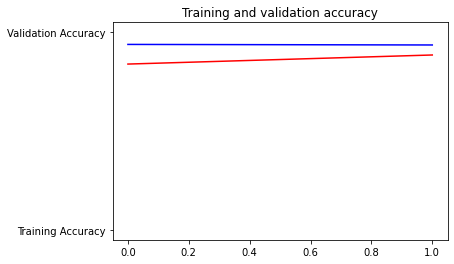

<Figure size 432x288 with 0 Axes>

In [26]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

